# 02 - MCMC Local Tests

The notebook simulates a simple Markov Chain Monte Carlo (MCMC) process to draw alternative school district boundaries based on a given set of initial boundaries.

In [1]:
import gerrychain
from gerrychain import Graph, Partition, MarkovChain
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from gerrychain.constraints import within_percent_of_ideal_population
from gerrychain.accept import always_accept
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely import wkt

In [2]:
df = pd.read_csv("data/partition_0.csv")
df.head(5)

,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,...,state,county,tract,index_right,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,area_sq_m
0,17031030101,127283,110999,41.991054,-87.654879,"POLYGON ((-9758303.87055293 5159823.80123592, ...",3356.0,1654.0,2162.0,257400.0,...,17,31,30101,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,4.316511e+05
1,17031030701,69878,0,41.982745,-87.657966,POLYGON ((-9758273.820529005 5158526.221123091...,1525.0,796.0,894.0,301500.0,...,17,31,30701,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,1.265510e+05
2,17031070103,69094,0,41.926811,-87.642605,POLYGON ((-9756509.224887993 5150207.568996626...,1449.0,1073.0,1133.0,-666666666.0,...,17,31,70103,24.0,609738.0,"2001 N ORCHARD ST CHICAGO, IL 60614",HS,"9, 10, 11, 12",LINCOLN PARK HS,1.249117e+05
3,17031807900,2013730,0,42.004189,-87.748780,POLYGON ((-9769643.427071452 5161260.299829107...,4295.0,2540.0,1404.0,595500.0,...,17,31,807900,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.649402e+06
4,17031808001,2202703,0,42.007021,-87.735406,POLYGON ((-9767645.560950026 5163280.861289486...,3634.0,2238.0,1370.0,458600.0,...,17,31,808001,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.992220e+06


In [3]:
print(f"Handling missing SCHOOL_ID (found {df['SCHOOL_ID'].isnull().sum()})...")

Handling missing SCHOOL_ID (found 0)...


In [4]:
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [5]:
gdf.head(5)

,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,...,state,county,tract,index_right,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,area_sq_m
0,17031030101,127283,110999,41.991054,-87.654879,"POLYGON ((-9758303.871 5159823.801, -9758278.1...",3356.0,1654.0,2162.0,257400.0,...,17,31,30101,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,4.316511e+05
1,17031030701,69878,0,41.982745,-87.657966,"POLYGON ((-9758273.821 5158526.221, -9758248.1...",1525.0,796.0,894.0,301500.0,...,17,31,30701,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,1.265510e+05
2,17031070103,69094,0,41.926811,-87.642605,"POLYGON ((-9756509.225 5150207.569, -9756464.3...",1449.0,1073.0,1133.0,-666666666.0,...,17,31,70103,24.0,609738.0,"2001 N ORCHARD ST CHICAGO, IL 60614",HS,"9, 10, 11, 12",LINCOLN PARK HS,1.249117e+05
3,17031807900,2013730,0,42.004189,-87.748780,"POLYGON ((-9769643.427 5161260.3, -9769621.608...",4295.0,2540.0,1404.0,595500.0,...,17,31,807900,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.649402e+06
4,17031808001,2202703,0,42.007021,-87.735406,"POLYGON ((-9767645.561 5163280.861, -9767619.2...",3634.0,2238.0,1370.0,458600.0,...,17,31,808001,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.992220e+06


In [6]:
known_crs = "EPSG:3857" 
gdf.crs = known_crs

In [7]:
gdf = gdf.set_index('GEOID')
gdf.head(5)

,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,mrent,...,state,county,tract,index_right,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,area_sq_m
GEOID,,,,,,,,,,,,,,,,,,,,,
17031030101,127283,110999,41.991054,-87.654879,"POLYGON ((-9758303.871 5159823.801, -9758278.1...",3356.0,1654.0,2162.0,257400.0,1209.0,...,17,31,30101,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,4.316511e+05
17031030701,69878,0,41.982745,-87.657966,"POLYGON ((-9758273.821 5158526.221, -9758248.1...",1525.0,796.0,894.0,301500.0,993.0,...,17,31,30701,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,1.265510e+05
17031070103,69094,0,41.926811,-87.642605,"POLYGON ((-9756509.225 5150207.569, -9756464.3...",1449.0,1073.0,1133.0,-666666666.0,1667.0,...,17,31,70103,24.0,609738.0,"2001 N ORCHARD ST CHICAGO, IL 60614",HS,"9, 10, 11, 12",LINCOLN PARK HS,1.249117e+05
17031807900,2013730,0,42.004189,-87.748780,"POLYGON ((-9769643.427 5161260.3, -9769621.608...",4295.0,2540.0,1404.0,595500.0,-666666666.0,...,17,31,807900,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.649402e+06
17031808001,2202703,0,42.007021,-87.735406,"POLYGON ((-9767645.561 5163280.861, -9767619.2...",3634.0,2238.0,1370.0,458600.0,2972.0,...,17,31,808001,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.992220e+06


In [8]:
# remove duplicates based on the index
gdf = gdf[~gdf.index.duplicated(keep='first')]

print(f"Shape after removing duplicates: {gdf.shape}")
print(f"Any duplicates now? {gdf.index.has_duplicates}")

Shape after removing duplicates: (850, 21)
Any duplicates now? False


Build connectivity graph.

In [9]:
graph = Graph.from_geodataframe(gdf)

In [10]:
gdf['SCHOOL_ID'] = gdf['SCHOOL_ID'].astype('str')
graph.add_data(gdf, columns=['pop', 'SCHOOL_ID'])


## Updaters

In [11]:
updaters = {
    "population": Tally("pop", alias="population"), # Use 'pop' column
    "cut_edges": cut_edges, # Counts how many boundaries are cut
}

In [12]:
initial_partition = Partition(
    graph,
    assignment="SCHOOL_ID", # Use 'SCHOOL_ID' column
    updaters=updaters
)

print("Initial population per school:")
print(initial_partition["population"])

Initial population per school:
{'609730.0': 146343.0, '609738.0': 125909.0, '609734.0': 152595.0, '609724.0': 40646.0, '609704.0': 71901.0, '609719.0': 114853.0, '609740.0': 167112.0, '609723.0': 58176.0, '609727.0': 134890.0, '610587.0': 25896.0, '609705.0': 88248.0, '610384.0': 33096.0, '609735.0': 55467.0, '609764.0': 32301.0, '609715.0': 97044.0, '610323.0': 47672.0, '609709.0': 59414.0, '609710.0': 69393.0, '609682.0': 27829.0, '609716.0': 36630.0, '609722.0': 63001.0, '609746.0': 42825.0, '610592.0': 35506.0, '609759.0': 71375.0, '609695.0': 67804.0, '609713.0': 32403.0, '609733.0': 72300.0, '609739.0': 42037.0, '609674.0': 55612.0, '610518.0': 51340.0, '609708.0': 77057.0, '609729.0': 98776.0, '610389.0': 48138.0, '609732.0': 142522.0, '609725.0': 91190.0, '609762.0': 16635.0, '610543.0': 9770.0, '609741.0': 55189.0, '609718.0': 57635.0, '609698.0': 107161.0, '609712.0': 55699.0, '609761.0': 30282.0, '609728.0': 48678.0, '609691.0': 22038.0, '609756.0': 12663.0}


In [13]:
num_districts = len(initial_partition.parts)

ideal_population = sum(initial_partition["population"].values()) / num_districts
pop_tolerance = 0.40

constraints = [
    within_percent_of_ideal_population(initial_partition, pop_tolerance)
]

print(f"Ideal population: {ideal_population:.0f}, Tolerance: +/- {pop_tolerance*100}%")

Ideal population: 66512, Tolerance: +/- 40.0%


In [14]:
proposal = recom(
    initial_partition,
    pop_col="pop", 
    pop_target=ideal_population,
    epsilon=pop_tolerance,
    node_repeats=100
)

/Users/zixuanzhou/Desktop/Grad School/Courses/MACS 30123/.venv/lib/python3.11/site-packages/gerrychain/tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(


RuntimeError: Could not find a possible cut after 100000 attempts.

In [ ]:
from gerrychain.tree import recursive_tree_part

print("\n--- Generating a NEW Starting Partition ---")
num_districts = len(initial_partition.parts) 
new_assignment = recursive_tree_part(
    graph,                               
    parts=range(num_districts),           
    pop_target=ideal_population,          
    pop_col="pop",                        
    epsilon=pop_tolerance               
)

# 1. Define the NEW partition
new_initial_partition = Partition(
    graph,
    assignment=new_assignment,
    updaters=updaters
)
print("New initial partition created.")

# 2. Define constraints USING THE NEW partition
constraints = [
    within_percent_of_ideal_population(new_initial_partition, pop_tolerance)
]
print("Constraints defined.")

# 3. Define the proposal function USING THE NEW partition
def proposal_function(partition):
    return recom(
        partition,
        pop_col="pop",
        pop_target=ideal_population,
        epsilon=pop_tolerance,
        node_repeats=50
    )

print("Proposal function defined.")


# 4. Create the MarkovChain - CHECK THIS LINE VERY CAREFULLY
print("\n--- Creating MarkovChain ---")

try:
    chain = MarkovChain(
        proposal=proposal_function,     # <--- MUST be the recom function
        constraints=constraints,
        accept=always_accept, 
        initial_state=new_initial_partition, # <--- MUST be the Partition object
        total_steps=1000 
    )
    print("MarkovChain created successfully.")

except ValueError as e:
    print(f"ERROR: The new plan might still fail constraints: {e}")
    # This might mean you *still* need to widen pop_tolerance

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    raise # Reraise to see the full traceback

# 5. Run the loop (Your Step 8 code)
print("\n--- Running the Chain ---")

results = []
last_partition_for_loop = new_initial_partition # Start with the new one

# Check if we should run the chain
if len(new_initial_partition.parts) >= 2:
    for i, partition_step in enumerate(chain): # Use a different name here
        if (i + 1) % 100 == 0:
            print(f"  ... Step {i + 1}")
        
        district_populations = list(partition_step["population"].values())
        results.append({
            'step': i + 1,
            'cut_edges': len(partition_step['cut_edges']),
            'min_pop': min(district_populations),
            'max_pop': max(district_populations),
            'pop_range': max(district_populations) - min(district_populations),
        })
        last_partition_for_loop = partition_step # Update with the latest
else:
    print("Not enough districts to run the chain.")

print("Chain finished (or skipped).")
df_results = pd.DataFrame(results)
print("\nSimulation Results:")
print(df_results.head())


--- Generating a NEW Starting Partition ---
New initial partition created.
Constraints defined.
Proposal function defined.

--- Creating MarkovChain ---
MarkovChain created successfully.

--- Running the Chain ---
  ... Step 100
  ... Step 200
  ... Step 300
  ... Step 400
  ... Step 500
  ... Step 600
  ... Step 700
  ... Step 800
  ... Step 900
  ... Step 1000
Chain finished (or skipped).

Simulation Results:
   step  cut_edges  min_pop  max_pop  pop_range
0     1        607  40785.0  92338.0    51553.0
1     2        608  40785.0  92338.0    51553.0
2     3        604  43348.0  92338.0    48990.0
3     4        602  43348.0  90834.0    47486.0
4     5        588  43348.0  90834.0    47486.0


Some visualizations.

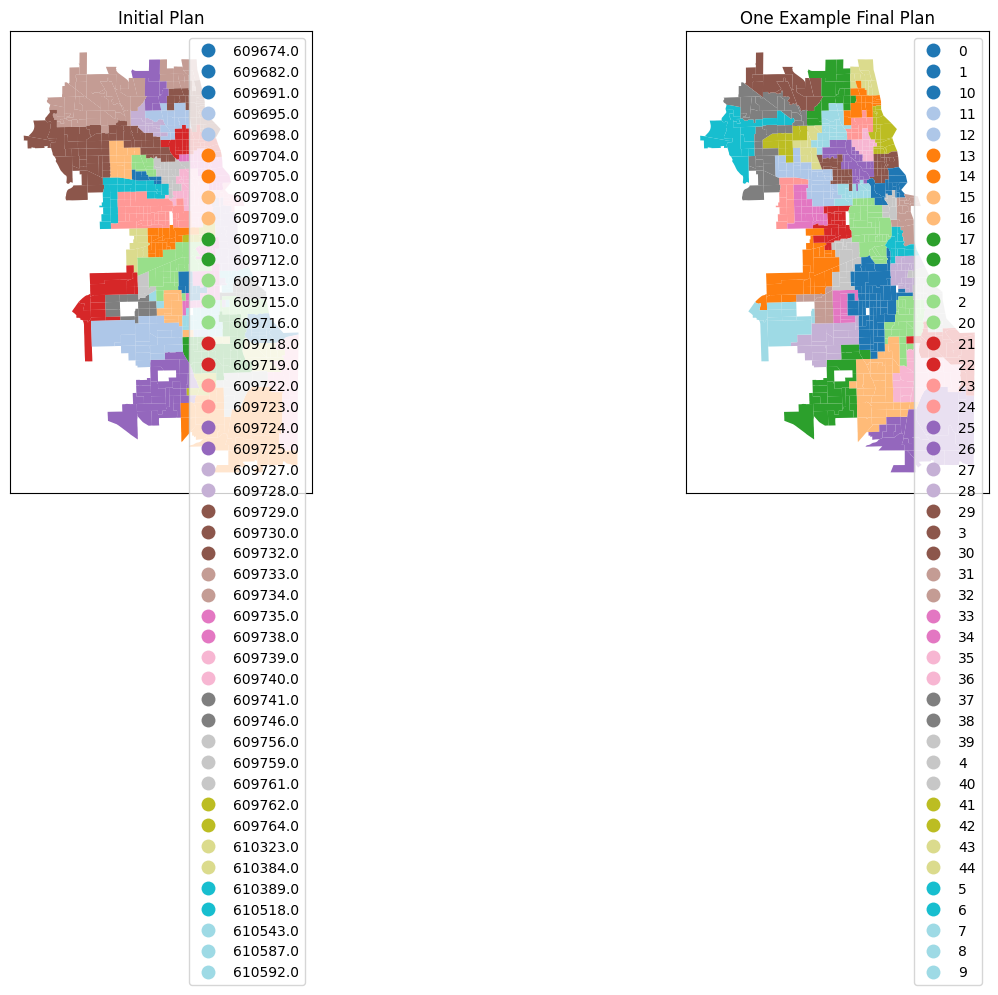

In [ ]:
# Add the final district assignment back to our GeoDataFrame
gdf['FINAL_DISTRICT'] = gdf.index.map(last_partition_for_loop.assignment)
# Turn the IDs into strings so GeoPandas stops treating them as numbers
gdf["SCHOOL_ID"] = gdf["SCHOOL_ID"].astype(str)
gdf['FINAL_DISTRICT'] = gdf['FINAL_DISTRICT'].astype(str)

# Plotting the results
# Plot initial vs. final
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
gdf.plot(column="SCHOOL_ID",
         cmap="tab20",
         categorical=True,           # <── key flag
         legend=False,               # huge legend would be unreadable
         edgecolor="white",
         linewidth=0.5,
         ax=axes[0])



gdf.plot(column='SCHOOL_ID', cmap='tab20', ax=axes[0], legend=True)
axes[0].set_title("Initial Plan")
axes[0].set_xticks([])
axes[0].set_yticks([])

gdf.plot(column='FINAL_DISTRICT', cmap='tab20', ax=axes[1], legend=True)
axes[1].set_title("One Example Final Plan")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()



In [ ]:
gdf.reset_index('GEOID', inplace=True)
gdf.head(5)

,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,...,county,tract,index_right,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,area_sq_m,FINAL_DISTRICT
0,17031030101,127283,110999,41.991054,-87.654879,"POLYGON ((-9758303.871 5159823.801, -9758278.1...",3356.0,1654.0,2162.0,257400.0,...,31,30101,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,4.316511e+05,14
1,17031030701,69878,0,41.982745,-87.657966,"POLYGON ((-9758273.821 5158526.221, -9758248.1...",1525.0,796.0,894.0,301500.0,...,31,30701,20.0,609730.0,"5900 N GLENWOOD AVE CHICAGO, IL 60660",HS,"9, 10, 11, 12",SENN HS,1.265510e+05,42
2,17031070103,69094,0,41.926811,-87.642605,"POLYGON ((-9756509.225 5150207.569, -9756464.3...",1449.0,1073.0,1133.0,-666666666.0,...,31,70103,24.0,609738.0,"2001 N ORCHARD ST CHICAGO, IL 60614",HS,"9, 10, 11, 12",LINCOLN PARK HS,1.249117e+05,29
3,17031807900,2013730,0,42.004189,-87.748780,"POLYGON ((-9769643.427 5161260.3, -9769621.608...",4295.0,2540.0,1404.0,595500.0,...,31,807900,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.649402e+06,30
4,17031808001,2202703,0,42.007021,-87.735406,"POLYGON ((-9767645.561 5163280.861, -9767619.2...",3634.0,2238.0,1370.0,458600.0,...,31,808001,23.0,609734.0,"6530 W BRYN MAWR AVE CHICAGO, IL 60631",HS,"9, 10, 11, 12",TAFT HS,3.992220e+06,30


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

Text(0.5, 1.0, 'Weighted Mean Income by School District, current plan')

<Figure size 1000x600 with 0 Axes>

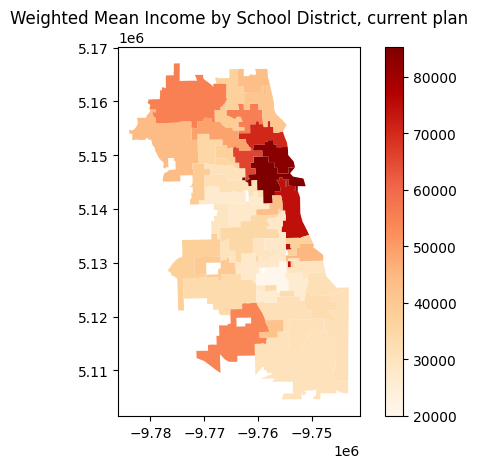

In [15]:
gdf["inc_times_pop"] = gdf["indinc"] * gdf["pop"]

districts = (
    gdf.dissolve(
        by="SCHOOL_ID",
        aggfunc={"inc_times_pop": "sum", "pop": "sum"},     # <-- just sums
        as_index=False,  # keeps the ID as a column, not index
    )
    .assign(w_mean_iinc=lambda d: d["inc_times_pop"] / d["pop"])
    .drop(columns=["inc_times_pop"])                        # optional clean-up
)

plt.figure(figsize=(10, 6))
districts.plot(column="w_mean_iinc", cmap="OrRd", legend=True)
plt.title("Weighted Mean Income by School District, current plan")

Note that the income distribution is now different. We can visualize this. 

<Axes: >

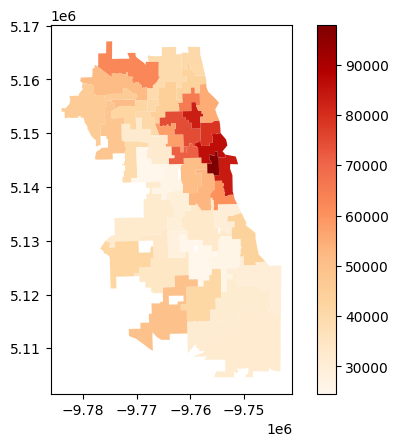

In [ ]:
districts = (
    gdf.dissolve(
        by="FINAL_DISTRICT",
        aggfunc={"inc_times_pop": "sum", "pop": "sum"},     # <-- just sums
        as_index=False,  # keeps the ID as a column, not index
    )
    .assign(w_mean_iinc=lambda d: d["inc_times_pop"] / d["pop"])
    .drop(columns=["inc_times_pop"])                        # optional clean-up
)


districts.plot(column="w_mean_iinc", cmap="OrRd", legend=True)

Compared with the original boundaries, the new boundaries lead to very different income distribution.